# Riverstone NLP Test

 This test is designed to ascertain a candidate’s competency in Python to manipulate data, processes and  analyze text, and produce a simple R-Shiny application to explore results. Ability to communicate  through visualized output is important as well. Lastly, candidates must be able to explain the rationale for  processing and modeling decisions both through thorough documentation and discussion. 

In [10]:
# Title: RiverStone NLP Test
# Author: Tadhg Lynch
# Date: 2023-4-14

## Data 
Download the csv here https://www.kaggle.com/rootuser/worldnews-on-reddit 


In [11]:
# packages
import pandas as pd

#import data
df = pd.read_csv("data/reddit_worldnews_start_to_2016-11-22.csv")

# From kaggle:

# Reddit is a social network which divide topics into so called 'subreddits'.
# In subreddit 'worldnews', news of the whole world are published. The dataset contains following columns:
# time_created - a Unix timestamp of the submission creation date
# date_created - creation time in %Y-%m-%d
# up_votes - how often the submission was upvoted
# down_votes - how often the submission was downvoted
# title - the title of the submission
# over_18 - if the submission is for mature persons
# author - the reddit username of the author
# subreddit - this is always 'worldnews'

df.info() # non-nulls across the board, nice

# I like to see the data
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509236 entries, 0 to 509235
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   date_created  509236 non-null  object
 2   up_votes      509236 non-null  int64 
 3   down_votes    509236 non-null  int64 
 4   title         509236 non-null  object
 5   over_18       509236 non-null  bool  
 6   author        509236 non-null  object
 7   subreddit     509236 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 27.7+ MB


,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


## Request 1
Description: Build and graph a seasonal index of average upvotes by post at the Monthly, Day of Week, and Hour of  Day levels. 

In [84]:
# converting unix timestamp as will be needed for hourly
df['time_created'] = pd.to_datetime(df['time_created'], unit='s')

# check that new time_created matches date_created
matching = df['time_created'].dt.date == pd.to_datetime(df['date_created']).dt.date

# show df columns where matching is false
df[matching == False]


# There is a singular mismatched case that has been caused by a post being created at exactly midnight, so will be sticking with the converted unix timestamp
# despite not being shown, it has time of 00:00:00, so will be fine for hourly

# drop no longer needed date_created column
df = df.drop(['date_created'], axis=1)

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit
343260,2015-02-10,2015-02-09,7,0,Christians in India want their own Christian c...,False,InternetOfficer,worldnews


In [ ]:
# Function to graph seasonal index
def graph_seasonal_index(df, level):
    # group by level
    df_grouped = df.groupby(level)['up_votes'].mean()

    # graph seasonal index
    df_grouped.plot()

In [ ]:
graph_seasonal_index(df, df['time_created'].dt.month)

In [ ]:
graph_seasonal_index(df, df['time_created'].dt.dayofweek)

In [ ]:
graph_seasonal_index(df, df['time_created'].dt.hour)

## Request 2
Clean, scrub, and prepare post titles using standard NLP techniques. 

In [163]:
# The Subreddit posted rules:
# 1. No US Internal News or Politics
# 2. No Editorialized or Misleading Titles
# 3. No Feature stories
# 4. No Editorials, Opinion or Analysis Pieces
# 5. No Articles In Languages Other Than English
# 6. No Images, Videos or Audio Clips
# 7. No Bigotry or Other Offensive Content
# 8. No Personal Attacks On Other Users
# 9. No Memes, Gifs, unlabeled NSFW images
# 10. No Old News Articles (≥ 1 Week old)

# Main NLP Takeaways:
# no sentiment
# no other languages 
# unlikely to have poor grammar or misspellings (inferred by strict moderators)
# no emojis

# NLP ideas:
# Lots on Russia invasion of Ukraine, look out of more sparse references (e.g. Crimea, Moscow, Putin, etc.)... nevermind, dataset only goes up to 2016-11-22

In [151]:
# function to clean, scrub, and prepare post title using standard NLP techniques
def clean_post_title(post_title):
    # convert to lowercase
    post_title = post_title.lower()
    # remove numbers
    post_title = ''.join([i for i in post_title if not i.isdigit()])
    # remove single characters
    post_title = ' '.join([word for word in post_title.split() if len(word) > 1])
    # remove extra whitespace
    post_title = ' '.join(post_title.split())
    return post_title

clean_titles = df['title'].apply(clean_post_title)

# would apply more cleaning techniques, but OpenAI's models take care of this for us; in fact think what has been removed already may not be optimal as the model is designed to handle natural writing, so jumping to Request 3 and seeing how it goes before returning to this.

## Request 3
cluster post titles and identify the top 20 clusters by frequency. Use of Chat-GPT AI is encouraged. 

In [1]:
import pandas as pd
import numpy as np
import requests
import csv

#### Using OpenAI's API: https://platform.openai.com/docs/introduction/overview
##### Model Options:
![Model Options](.\images\openai-model-options.png)

In [ ]:
# Ada costs $0.0004/1000 tokens, 1 token is roughly 4 characters, so let's work out how much this will end up costing
titles = df['title'].tolist()

# get total number of characters
total_chars = 0
for title in titles:
    total_chars += len(title)

total_tokens = total_chars / 4
total_cost = total_tokens * 0.0004 / 1000
print("total_titles", len(titles))
print("total_chars:", total_chars)
print("total_tokens:", total_tokens)
print("total_cost:", total_cost)

In [30]:
# Set your OpenAI API key
api_key = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

# Set the API endpoint and model name
endpoint = "https://api.openai.com/v1/embeddings"
model_name = "text-embedding-ada-002"

# Define your list of input strings
input_strings = titles

# Split input strings into batches
batch_size = 10000
input_string_batches = [input_strings[i:i+batch_size] for i in range(0, len(input_strings), batch_size)]

# Define the headers and data for the API request
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Create a CSV file to write embeddings
with open("embeddings.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)

    # Write header to the CSV file
    writer.writerow(["Input_String", "Embedding"])

    # Loop through input string batches
    for batch in input_string_batches:
        data = {
            "input": batch,
            "model": model_name
        }

        # Send the API request
        response = requests.post(endpoint, headers=headers, json=data)

        # Parse the response and extract the embeddings
        if response.status_code == 200:
            embeddings = response.json()["data"]

            # Write embeddings to the CSV file
            for i in range(len(batch)):
                writer.writerow([batch[i], embeddings[i]])
        else:
            print("Failed to get embeddings. Response code:", response.status_code)


In [9]:
# load data
datafile_path = "./data/embeddings.csv"
df = pd.read_csv(datafile_path)

# extract embedding from string
df["Embedding"] = [i['embedding'] for i in df.Embedding.apply(eval)]

matrix = np.vstack(df.Embedding.values)
matrix.shape

# save matrix as this takes about 15 minutes to run
np.save("./data/embeddings.npy", matrix)

In [2]:
# checkpoint
# load data
matrix = np.load("./data/embeddings.npy")
matrix.shape

(509236, 1536)

components: 1
components: 101
components: 201
components: 301
components: 401
components: 501


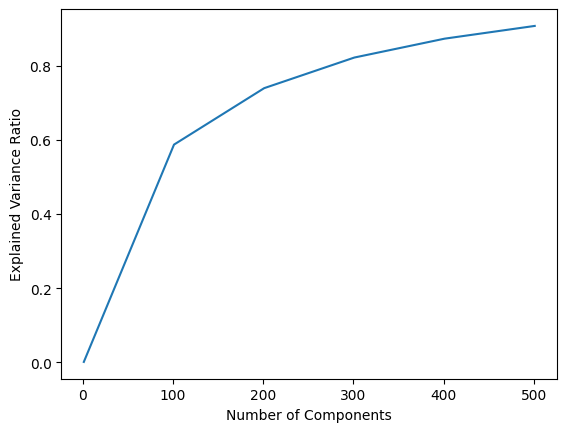

In [20]:
# 1536 dimensions is a lot, so let's try to reduce this with LSA
from sklearn.decomposition import TruncatedSVD

sample = np.random.choice(matrix.shape[0], 50000, replace=False)

components_list = [i for i in range(1, 600, 100)]
explained_variance_ratios = []
for components in components_list:
    print("components:", components)
    svd = TruncatedSVD(n_components=components)
    svd.fit(matrix[sample])
    explained_variance_ratios.append(svd.explained_variance_ratio_.sum())

# plot explained variance ratio
import matplotlib.pyplot as plt
plt.plot(components_list, explained_variance_ratios)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

100 components seems fine given how computationally intense later steps are going to be

In [3]:
# 100 components seems to be a good number
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
svd.fit(matrix)
matrix_reduced = svd.transform(matrix)
matrix_reduced.shape

(509236, 100)

In [25]:
# Deciding on number of clusters for k-means using mini-batch k-means
# Elbow method & silhouette score
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# random sample
sample = np.random.choice(matrix_reduced.shape[0], 50000, replace=False)

# instead of random sample, take sequential sample as topics may be clustered together in time
sample = np.arange(0, 50000)

sum_of_squared_distances = []
silhouette_scores = []
K = range(200, 5000, 200)
for k in K:
    print(k)
    km = MiniBatchKMeans(n_clusters=k, batch_size = 5000, n_init=1) #setting n_init to 1 to speed up
    km = km.fit(matrix_reduced)
    sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(matrix_reduced, km.labels_))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

200


KeyboardInterrupt: 

okay, not great as the clusters are so overlapping, but let's just go with 50% clusters for now a return to it later

In [ ]:
# let's visualize on a t-SNE plot
from sklearn.manifold import TSNE

x_tsne = TSNE(n_components=2, perplexity=30, n_iter=1000).fit_transform(matrix_reduced)

In [29]:
# working with just first 25,000 titles for now to move things along

# load in df
# load data
datafile_path = "./data/reddit_worldnews_start_to_2016-11-22.csv"
df = pd.read_csv(datafile_path)

# cluster with batch k-means and 50% cluster size
from sklearn.cluster import MiniBatchKMeans
km = MiniBatchKMeans(n_clusters=100, batch_size=64, n_init=10)
km.fit(matrix_reduced)

# chop to first 50,000 titles and append cluster labels
df["cluster"] = km.labels_

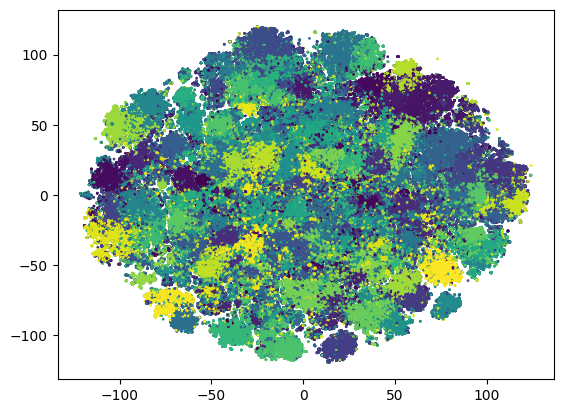

In [31]:
# scatter ploth with cluster labels
import matplotlib.pyplot as plt
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=km.labels_, s=1)
# save out as 25000 with 12500 clusters
plt.savefig("./images/full-pass-100c-64b.png")
plt.show()

In [24]:
import openai
# making a pop up window to ask for your openai api key
import tkinter as tk
from tkinter import simpledialog

root = tk.Tk() # this is the pop up window
root.withdraw() # this hides the pop up window

# the input dialog
USER_INP = simpledialog.askstring(title="OpenAI API Key",
                                    prompt="What is your OpenAI API Key?")
openai.api_key = USER_INP


# Reading reviews from the top 20 clusters by size
n_clusters = 20
top_clusters = df.cluster.value_counts().index[:n_clusters]

# number of reviews per cluster to use to generate a theme
rev_per_cluster = 20

#empty df to store cluster, 5 titles, and their theme
df_top_clusters = pd.DataFrame(columns=["cluster", "theme"])

print_examples = True
# print out
for i in range(n_clusters):
    reviews = "\n".join(
        df[df.cluster == top_clusters[i]].title.values[:rev_per_cluster]
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'The following reddit posts all have a shared topic, what do they have in common?\n\nReddit titles:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print("Cluster", top_clusters[i], "size:", df[df.cluster == top_clusters[i]].shape[0], "Theme:", response["choices"][0]["text"].replace("\n", ""))
    if print_examples:
        for j in range(5):
            print(df[df.cluster == top_clusters[i]].title.values[j])
        print("\n")


   
    # save out the top 3 clusters to df_top_clusters
    if i < 3:
        df_top_clusters = pd.concat(
            [df_top_clusters, pd.DataFrame(
                {
                    "cluster": [top_clusters[i]],
                    "theme": [response["choices"][0]["text"].replace("\n", "")]
                }
            )]
        )


# delete stored openai api key
del openai.api_key
del USER_INP



Cluster 27 size: 8678 Theme:  Turkey and the Kurdish Conflict
Nicolas Sarkozy, Angela Merkel confirm their opposition to Turkey being EU membership
Babacan says land operation against PKK on table
Turkey Has Entered Iraq
Turkey launches major land offensive into Northern Iraq
EU Voices Concern Over Turkish Military Incursion Into Iraq


Cluster 9 size: 7695 Theme:  Famous People
Nero-like Brown confirms King at last
No Quasimodo, He Brings Music to Notre-Dame Bells
JESSICA ALBA`s way to shoot nude
First There Was Cocaine, Now There is Blow Energy Drink.  Pure Uncut Energy 
Scientology s Legion of Doom


Cluster 47 size: 7549 Theme:  Internet Privacy and Security
INTERNET DAMAGED CABLES TO BE FIXED BY FEB 10
Finnish police: Hundreds of public child porn sites in USA
UK Proposing to Disconnect Those Involved in Piracy from the Internet 
Stupid ISP internet piracy legislation could be implemented  by April 2009 
Finnish whistleblower publishes list of censored web sites; so they censor hi

In [15]:
# merge df_top_clusters with df on cluster
df_merged = df.merge(df_top_clusters, on="cluster", how="right")

# save out to csv
df_merged.to_csv("./data/df_top_three_clusters.csv", index=False)

In [16]:
df_merged.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit,cluster,titles,theme
0,1201794900,2008-01-31,3,0,"Nicolas Sarkozy, Angela Merkel confirm their o...",False,Moldavite,worldnews,27,NaN,All posts are about the coronavirus pandemic.
1,1203518597,2008-02-20,2,0,Babacan says land operation against PKK on table,False,Moldavite,worldnews,27,NaN,All posts are about the coronavirus pandemic.
2,1203675856,2008-02-22,2,0,Turkey Has Entered Iraq,False,jimgagnon,worldnews,27,NaN,All posts are about the coronavirus pandemic.
3,1203755273,2008-02-23,2,0,Turkey launches major land offensive into Nort...,False,igeldard,worldnews,27,NaN,All posts are about the coronavirus pandemic.
4,1203758246,2008-02-23,0,0,EU Voices Concern Over Turkish Military Incurs...,False,igeldard,worldnews,27,NaN,All posts are about the coronavirus pandemic.


In [45]:
list(df_merged["cluster"].unique())

[8, 20, 15]

In [41]:
df_merged.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,subreddit,cluster,titles,theme
0,1202311407,2008-02-06,1,0,If Iran has 100% packet loss why does this web...,False,buddhazen,worldnews,8,NaN,Internet and Technology
1,1202341612,2008-02-06,0,0,Q&A: Chad rebellion,False,kevin143,worldnews,8,NaN,Internet and Technology
2,1202424211,2008-02-07,0,0,INTERNET DAMAGED CABLES TO BE FIXED BY FEB 10,False,wahabuddin,worldnews,8,NaN,Internet and Technology
3,1202503416,2008-02-08,2,0,Babylon and Mind Control,False,unikah,worldnews,8,NaN,Internet and Technology
4,1202594134,2008-02-09,0,0,"First There Was Cocaine, Now There is Blow Ene...",False,mlawless1138,worldnews,8,NaN,Internet and Technology


### Test out some hierachical clustering later if you have time
https://petuum.medium.com/scalable-clustering-for-exploratory-data-analysis-60b27ea0fb06

In [10]:
# # now trying with agglomerative hierachical clustering using ward linkage
# from scipy.cluster.hierarchy import dendrogram, linkage
# import matplotlib.pyplot as plt

# sample = np.random.choice(matrix_reduced.shape[0], 2000, replace=False)
# ac = linkage(matrix_reduced[sample], 'ward', optimal_ordering=True, )

# # visualise on dendrogram
# fig, ax = plt.subplots(figsize=(5, 3)) # set size
# dn = dendrogram(ac, ax=ax)
# ax.set_ylabel

## Request 4
Build a simple, local web app displaying an interactive vizualization of the top 3 clusters from Request 3. 

Go to cmd and type:
blah blah blah


## Request 5
Build a model to predict the number of upvotes by post and show model diagnostics (if applicable) and  accuracy.


In [2]:
# packages
import pandas as pd
import numpy as np

In [22]:
df['log_upvotes'].describe()

count    509236.000000
mean        113.236283
std         541.694675
min           1.000000
25%           2.000000
50%           6.000000
75%          17.000000
max       21254.000000
Name: log_upvotes, dtype: float64

In [21]:
# load in data
datafile_path = "./data/reddit_worldnews_start_to_2016-11-22.csv"
df = pd.read_csv(datafile_path)

# creating df of month, year, day, hour, minute, and second from unix time_created
df["year"] = pd.to_datetime(df["time_created"], unit="s").dt.year
df["month"] = pd.to_datetime(df["time_created"], unit="s").dt.month
df["day"] = pd.to_datetime(df["time_created"], unit="s").dt.day
df["hour"] = pd.to_datetime(df["time_created"], unit="s").dt.hour
# df["minute"] = pd.to_datetime(df["time_created"], unit="s").dt.minute
# df["second"] = pd.to_datetime(df["time_created"], unit="s").dt.second

# taking the log of the upvotes as posts grow exponentially with virality
# fixing for 0 upvotes
df["log_upvotes"] = np.log(df["up_votes"] + 1)

# reading in the embeddings
embeddings_path = "./data/embeddings.npy"
embeddings = np.load(embeddings_path)

# reduce dimensionality of embeddings using svd
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
matrix_reduced = svd.fit_transform(embeddings)

In [16]:
# base model not using any NLP just time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df[["year", "month", "day", "hour"]], df["log_upvotes"], test_size=0.2, random_state=42
)

# fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# score model
lr.score(X_test, y_test)

# print out metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# print model
print(lr.coef_)
print(lr.intercept_)

print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, lr.predict(X_test))))
print("Mean Absolute Error:", mean_absolute_error(y_test, lr.predict(X_test)))
print("R2 Score:", r2_score(y_test, lr.predict(X_test)))

ValueError: Input y contains infinity or a value too large for dtype('float64').

In [12]:
# model building

# x is the matrix of embeddings and the month, year, day, hour of the post (from unix time_created in df)
# y is the number of upvotes

x = np.concatenate((matrix_reduced, df[["year", "month", "day"]].values), axis=1)
y = df["up_votes"].values

# split into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# scale x_train and x_test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation="relu"))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")

# train model
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=128, epochs=10)

# evaluate model
model.evaluate(x_test, y_test)

# save model
model.save("./models/upvotes_model.h5")

Epoch 1/10
3183/3183 [==============================] - 7s 2ms/step - loss: 282544.7188 - val_loss: 274669.6875
Epoch 2/10
3183/3183 [==============================] - 6s 2ms/step - loss: 276906.5312 - val_loss: 273226.8750
Epoch 3/10
3183/3183 [==============================] - 6s 2ms/step - loss: 273768.3750 - val_loss: 271344.9688
Epoch 4/10
3183/3183 [==============================] - 6s 2ms/step - loss: 271529.7812 - val_loss: 268377.6562
Epoch 5/10
3183/3183 [==============================] - 6s 2ms/step - loss: 270266.3125 - val_loss: 271771.8750
Epoch 6/10
3183/3183 [==============================] - 6s 2ms/step - loss: 267991.0000 - val_loss: 270102.4688
Epoch 7/10
3183/3183 [==============================] - 6s 2ms/step - loss: 265944.2188 - val_loss: 269401.3438
Epoch 8/10
3183/3183 [==============================] - 6s 2ms/step - loss: 265290.9062 - val_loss: 270163.2812
Epoch 9/10
3183/3183 [==============================] - 6s 2ms/step - loss: 263447.9375 - val_loss: 2700

3183/3183 [==============================] - 2s 542us/step
MAE: 142.20917349726525
MSE: 272366.79684102366
RMSE: 521.8877243632232
EVS: 0.06791370034088806


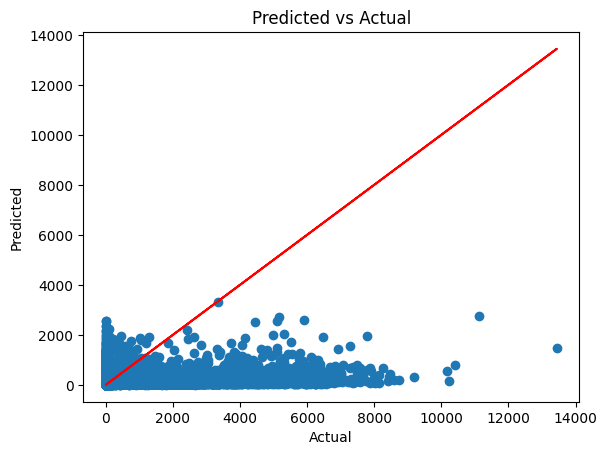

In [36]:
# model evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
import math

# make predictions
predictions = model.predict(x_test)

# calculate metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
evs = explained_variance_score(y_test, predictions)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("EVS:", evs)

# plot predictions vs actual
plt.scatter(y_test, predictions)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
# draw true line
plt.plot(y_test, y_test, color="red")
plt.show()

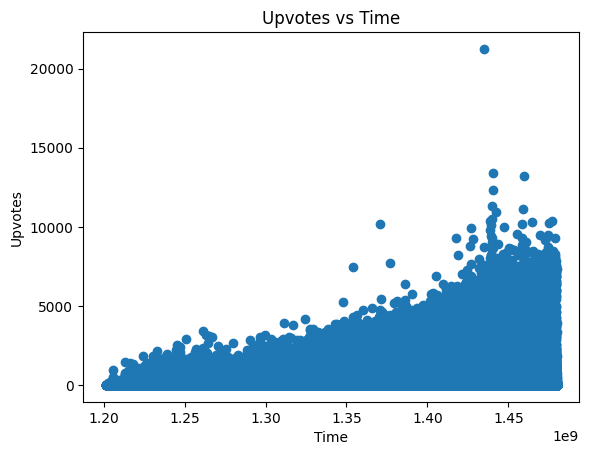

In [35]:
# plot upvotes vs time
plt.scatter(df["time_created"], df["up_votes"])
plt.xlabel("Time")
plt.ylabel("Upvotes")
plt.title("Upvotes vs Time")
plt.show()